In [1]:
from pathlib import Path
import numpy as np

from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)

In [2]:
from mtpy import MTCollection
mc = MTCollection()
mc.open_collection(Path(r"../../data/transfer_functions/musgraves_tf.h5"))
#mc.open_collection(Path(r"../../../scratch/nm05/jp0633/musgraves_edis/musgraves_tf.h5"))

from ipywidgets import widgets, interact
station_names = mc.dataframe.station.values
def foo(name, component):
    tf = mc.get_tf(name)
    tf.plot_mt_response()
Q = interact(
    foo, 
    name=widgets.Select(options=station_names, value='SAA300'),
    component=widgets.RadioButtons(options=['xy', 'yx', 'det'], value='det')
)

interactive(children=(Select(description='name', index=28, options=('SA225_2', 'SA26W2', 'SA274_2', 'SA295', '…

23:11:07T18:42:59 | WARNING | line:283 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SAA300. Suggest setting survey, otherwise returning the TF from survey Musgraves_SA.


Text(0.5, 1.0, 'SAA300')

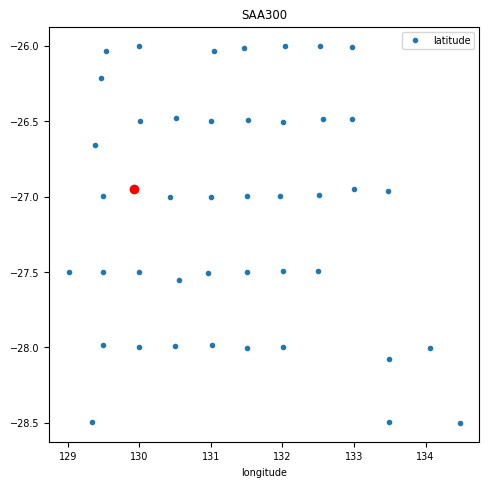

In [3]:
name = Q.widget.kwargs['name']
component = Q.widget.kwargs['component']
tf = mc.get_tf(name)

fig, ax = plt.subplots(1,1, figsize=(5,5))
mc.dataframe.plot(x='longitude', y='latitude', marker='.', linestyle='None', ax=ax)
ax.plot(tf.longitude, tf.latitude, 'ro')
ax.set_title(name)

In [4]:
if component == 'xy':
    print ('>> Use Zxy')
    dobs = np.c_[tf.Z.res_xy, tf.Z.phase_xy].flatten()
    dobs_error = np.c_[tf.Z.res_error_xy, tf.Z.phase_error_xy].flatten()
elif component == 'yx':
    print ('>> Use Zyx')
    dobs = np.c_[tf.Z.res_yx, tf.Z.phase_yx].flatten()
    dobs_error = np.c_[tf.Z.res_error_yx, tf.Z.phase_error_yx].flatten()    
elif component == 'det':
    print ('>> Use determinant')
    dobs = np.c_[tf.Z.res_det, tf.Z.phase_det].flatten()
    dobs_error = np.c_[tf.Z.res_error_det, tf.Z.phase_error_det].flatten()    
    
frequencies = tf.frequency

>> Use determinant


C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy-v2\mtpy\core\transfer_function\z.py:570: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))


In [5]:
dz = 50
n_layer = 31
z_factor = 1.2
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]

In [6]:
def run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    use_irls=False,
    p_s=2,
    p_z=2
    
):
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, reference_model=mref, mapping=maps.IdentityMap(mesh_inv))

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)

    # Define the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # Define Inversion Directives
    # ---------------------------
    #
    # Here we define any directives that are carried out during the inversion. This
    # includes the cooling schedule for the trade-off parameter (beta), stopping
    # criteria for the inversion and saving inversion results at each iteration.
    #

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    # Set the rate of reduction in trade-off parameter (beta) each time the
    # the inverse problem is solved. And set the number of Gauss-Newton iterations
    # for each trade-off paramter value.
    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Setting a stopping criteria for the inversion.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)
    if use_irls:
        reg.norms = np.c_[p_s, p_z]
        # Reach target misfit for L2 solution, then use IRLS until model stops changing.
        IRLS = directives.Update_IRLS(max_irls_iterations=40, minGNiter=1, f_min_change=1e-5)

        # The directives are defined as a list.
        directives_list = [
            IRLS,
            starting_beta,
            save_dictionary,
        ]
    else:
        # The directives are defined as a list.
        directives_list = [
            starting_beta,
            beta_schedule,
            target_misfit,
            save_dictionary
        ]

    #####################################################################
    # Running the Inversion
    # ---------------------
    #
    # To define the inversion object, we need to define the inversion problem and
    # the set of directives. We can then run the inversion.
    #

    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)

    # Run the inversion
    recovered_model = inv.run(m0)    
    
    return recovered_model, save_dictionary.outDict

In [7]:
relative_error_rho = 0.05
floor_phase = 2.
rho_app = dobs.reshape((len(frequencies), 2))[:,0]
phase = dobs.reshape((len(frequencies), 2))[:,1]
standard_deviation = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten() 
# standard_deviation += dobs_error
rho_0 = 100
rho_ref = 100.

In [8]:
recovered_model, output_dict = run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1
)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.54e+07  2.00e+06  0.00e+00  2.00e+06    1.59e+06      0              
   1  7.70e+06  2.55e+05  2.70e-06  2.55e+05    1.60e+05      0              
   2  3.85e+06  2.98e+04  9.99e-06  2.98e+04    1.77e+04      0   Skip BFGS  
   3  1.93e+06  3.56e+03  1.92e-05  3.60e+03    2.43e+03      0   Skip BFGS  
   4  9.63e+05  9.90e+02  4.09e-05  1.03e+03    3.68e+02      0   Skip BFGS  
   5  4.81e+05  7.82e+02  8.74e-05  8.24e+02    6.76e+01      0   Skip BFGS  
   6  2.41e+05  7.39e+02  1.43e

In [9]:
target_misfit = dobs.size / 2.
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']

In [10]:
matplotlib.rcParams['font.size'] = 14
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()

In [11]:
from ipywidgets import interact, widgets
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=10, description='iteration', max=10, min=1), RadioButtons(description='s…

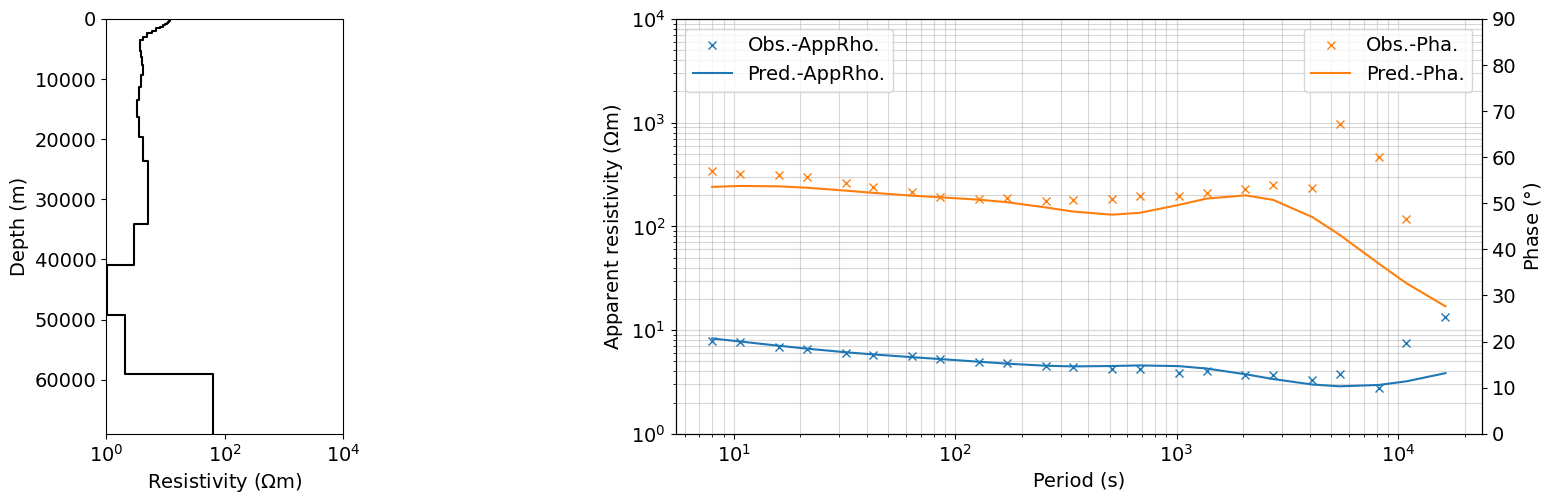

In [12]:
iteration = Q_iter.widget.kwargs['iteration']
dpred = output_dict[iteration]['dpred']
m = output_dict[iteration]['m']
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(m)))[::-1],
    ax=ax0,
    color="k",**{'linestyle':'-'},
)
# ax0.legend()
ax0.set_xlabel("Resistivity ($\Omega$m)")
# ax0.set_xlim(1, 1e4)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label='Obs.-AppRho.')
ax.loglog(1./frequencies, dpred.reshape((len(frequencies), 2))[:,0], color='C0', label='Pred.-AppRho.')

ax_1 = ax.twinx()
ax_1.plot(1./frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label='Obs.-Pha.')
ax_1.plot(1./frequencies, dpred.reshape((len(frequencies), 2))[:,1], color='C1', label='Pred.-Pha.')
ax.set_xlabel("Period (s)")
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel("Phase ($\degree$)")
# ax.legend(bbox_to_anchor=(1.1,1))
ax.legend(loc=2)
ax_1.legend(loc=1)
ax.set_ylim(1, 10000)
ax_1.set_ylim(0, 90)    
ax0.set_xlim(1, 10000)
plt.show()

## Plot using `MTpy`?

In [13]:
from mtpy import MT
from mtpy.core.transfer_function.z import Z
n_freq = len(frequencies)
app_rho_matrix = np.zeros((n_freq, 2, 2), dtype=float)
phase_matrix = np.zeros((n_freq, 2, 2), dtype=float)
app_rho_matrix[:,0,1] = dpred.reshape((len(frequencies), 2))[:,0]
app_rho_matrix[:,1,0] = dpred.reshape((len(frequencies), 2))[:,0]
phase_matrix[:,0,1] = dpred.reshape((len(frequencies), 2))[:,1]
phase_matrix[:,1,0] = dpred.reshape((len(frequencies), 2))[:,1]-180
# or add apparent resistivity and phase
z_object = Z()
z_object.set_resistivity_phase(app_rho_matrix, phase_matrix, frequencies)

tf_pred = MT()  
tf_pred.Z = z_object

tf_pred.survey_metadata.id = tf.survey
tf_pred.station_metadata.id = f"{tf.station}_pred"
tf_pred.station_metadata.transfer_function.id = f"{tf.station}_pred"
# if this is 2D maybe we need a location
tf_pred.station_metadata.location.latitude = tf.station_metadata.location.latitude 
tf_pred.station_metadata.location.longitude = tf.station_metadata.location.longitude
mc.add_tf(tf_pred)

23:11:07T18:43:10 | WARNING | line:283 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SAA300. Suggest setting survey, otherwise returning the TF from survey Musgraves_SA.
23:11:07T18:43:10 | WARNING | line:283 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SAA300_pred. Suggest setting survey, otherwise returning the TF from survey Musgraves_SA.


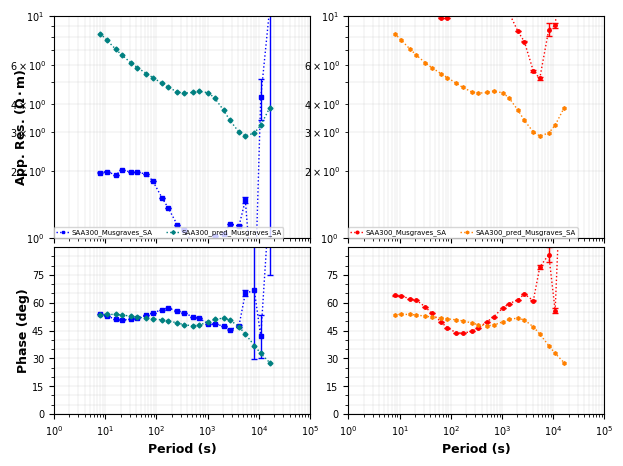

In [14]:
plot_compare = mc.plot_mt_response([tf.station, tf_pred.station], plot_style="compare", plot_tipper='n')

In [17]:
recovered_model_ps_2_pz_0, output_dict_ps_2_pz_0 = run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=40,
    maxIterCG=30,
    alpha_s=1E-5,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    use_irls=True,
    p_s=2,
    p_z=0
)

ValueError: The number of values provided for 'norms', 1, does not match the number of regularization functions, 2.

In [ ]:
recovered_model_ps_0_pz_0, output_dict_ps_0_pz_0 = run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=40,
    maxIterCG=30,
    alpha_s=1,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    use_irls=True,
    p_s=0,
    p_z=0
)

In [ ]:
matplotlib.rcParams['font.size'] = 12
fig, axs = plt.subplots(1,3, figsize=(8, 5))
ax1, ax2, ax3 = axs
plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(recovered_model)))[::-1],
    ax=ax1,
    color="k",**{'linestyle':'-'},
)

plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(recovered_model_ps_2_pz_0)))[::-1],
    ax=ax2,
    color="k",**{'linestyle':'-'},
)

plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(recovered_model_ps_0_pz_0)))[::-1],
    ax=ax3,
    color="k",**{'linestyle':'-'},
)
titles = ["Smooth", "Sharp", "Sharp+Compact"]
for ii, ax in enumerate(axs):
    ax.set_xlabel("Resistivity ($\Omega$m)")
    if ii>0:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    ax.set_title(titles[ii])
    ax.set_xlim(1, 1000)
plt.tight_layout()

In [ ]:
mc.close_collection()